In [4]:
import pyodbc
from meyerDB import cable_connection
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
import sklearn.preprocessing as pp

# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

Database connection ok


In [28]:
# Area spesific cable quantities
# Predictors:
# Area type
# Algorithms:
# Mean

# Get the data
cursor.execute("SELECT DISTINCT project_id FROM routed")
data = np.array(cursor.fetchall()).astype('int32')
X = data[:, 0]
# init lpo split
p = 2 #ships
lpo = LeavePOut(p)
# train and evaluate model with lpo
scores = []
for train_i, test_i in lpo.split(X):
    s1 = X[test_i[0]]
    s2 = X[test_i[1]]
    cursor.execute(
        "SELECT pred, real_count FROM ("
        " SELECT predictions.avg_count as pred, count(*) as real_count FROM area_dataset"
        " LEFT JOIN ("
        " SELECT area_type, avg(area_count) as avg_count FROM ("
        " SELECT project_id, area_dataset.area_type, area_dataset.area as area1, count(*) as area_count"
        " FROM area_dataset WHERE project_id<>{} AND project_id<>{} GROUP BY project_id, area_type, area_dataset.area) area_counts"
        " GROUP BY area_type"
        ") predictions ON predictions.area_type=area_dataset.area_type"
        " WHERE project_id={} OR project_id={}"
        " GROUP BY area_dataset.area, predictions.avg_count"
        ") t2 WHERE pred IS NOT NULL"
        .format(s1,s2,s1,s2)
    )
    data = np.array(cursor.fetchall())
    preds = data[:, 0]
    y_test = data[:, -1]
    scores.append(mape(y_test, preds))
    
scores = np.array(scores)
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
table_rows.append(('Mean', 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)



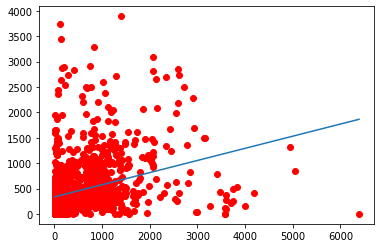

9.928015


KeyboardInterrupt: 

In [10]:
# Area specific cable quantities
# Predictors:
# Area squares
# Algorithms:
# Linear regression

# Get the data

# get area types
cursor.execute("SELECT DISTINCT area_type FROM areas")
area_types = [item for t in cursor.fetchall() for item in t]

#get ship data
cursor.execute("SELECT project_id FROM routed GROUP BY project_id")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]

# init regression model
model = linear_model.LinearRegression()

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)
# train and evaluate model with lpo
scores = []
for train_i, test_i in lpo.split(ships):
    # update area squares linear model coefficients and predictions
    cursor.execute("UPDATE areas SET pred_count = NULL")
    cursor.commit()
    s1 = ships[test_i[0]]
    s2 = ships[test_i[1]]
    cursor.execute(
        "SELECT squares, count(*) as cables FROM area_dataset"
        " LEFT JOIN areas ON areas.project_id=area_dataset.project_id AND areas.area=area_dataset.area"
        " WHERE area_dataset.project_id<>{} AND area_dataset.project_id<>{} AND squares IS NOT NULL"
        " GROUP BY area_dataset.area, squares"
        .format(s1, s2)
        )
    data = np.array(cursor.fetchall()).astype('float32')
    if data.shape[0] == 0:
        continue
    X = data[:, 0].reshape((-1, 1))
    y = data[:, -1]
    model.fit(X, y)
    pred = model.predict(X)
    plt.plot(X.ravel(), y, 'ro')
    plt.plot(X.ravel(), pred)
    plt.show()
    print(mape(y, pred))
    input('pause')
    cursor.execute(
        "UPDATE areas SET areas.pred_count=areas.squares*{} + {}"
        .format(model.coef_[0], model.intercept_)
        )
    cursor.commit()
    cursor.execute(
        "SELECT pred_count, count(*) as real_count FROM area_dataset"
        " LEFT JOIN areas ON areas.project_id=area_dataset.project_id AND areas.area=area_dataset.area"
        " WHERE (area_dataset.project_id={} or area_dataset.project_id={}) AND pred_count IS NOT NULL"
        " GROUP BY pred_count, area_dataset.area"
        .format(s1, s2)
        )
    data = np.array(cursor.fetchall()).astype('float32')
    preds = data[:, 0]
    y_test = data[:, 1]
    scores.append(r2_score(y_test, preds))

scores = np.array(scores)
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
table_rows.append(('Linear regression', 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)

In [15]:
# Area specific cable quantities
# Predictors:
# Area squares
# Area type
# Algorithms:
# Linear regression

# Get the data

# get area types
cursor.execute("SELECT DISTINCT area_type FROM areas")
area_types = [item for t in cursor.fetchall() for item in t]

#get ship data
cursor.execute("SELECT project_id FROM routed GROUP BY project_id")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]

# init regression model
model = linear_model.LinearRegression()

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)
# train and evaluate model with lpo
scores = []
for train_i, test_i in lpo.split(ships):
    # update area squares linear model coefficients and predictions
    cursor.execute("UPDATE areas SET pred_count = NULL")
    cursor.commit()
    s1 = ships[test_i[0]]
    s2 = ships[test_i[1]]
    for area_type in area_types:
        cursor.execute(
            " SELECT squares, cable_count FROM ("
            " SELECT area_dataset.project_id, area_dataset.area, area_dataset.area_type, squares, count(*) as cable_count FROM area_dataset"
            " LEFT JOIN areas ON areas.project_id=area_dataset.project_id AND areas.area=area_dataset.area"
            " WHERE area_dataset.project_id<>{} AND area_dataset.project_id<>{}"
            " GROUP BY area_dataset.project_id, area_dataset.area, area_dataset.area_type, squares"
            " ) cable_counts"
            " WHERE area_type='{}' AND squares IS NOT NULL"
            .format(s1,s2,area_type)
        )
        data = np.array(cursor.fetchall()).astype('float32')
        if data.shape[0] == 0:
            continue
        X = data[:, [0]]
        y = data[:, -1]
        model.fit(X, y)
        cursor.execute(
            "UPDATE areas SET areas.pred_count=areas.squares*{} + {}"
            " WHERE areas.area_type='{}'"
            .format(model.coef_[0], model.intercept_, area_type)
            )
        cursor.commit()
    # calculate area predictions
    cursor.execute(
        "SELECT pred_count as preds, real_count FROM areas"
        " LEFT JOIN (SELECT project_id, area, count(*) as real_count FROM area_dataset"
        " GROUP BY project_id, area) as real_counts ON real_counts.project_id=areas.project_id AND areas.area=real_counts.area"
        " WHERE (areas.project_id={} OR areas.project_id={}) AND real_count IS NOT NULL AND pred_count IS NOT NULL"
        .format(s1, s2)
        )
    data = np.array(cursor.fetchall()).astype('float32')
    preds = data[:, 0]
    y_test = data[:, 1]
    scores.append(mape(y_test, preds))

scores = np.array(scores)
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
table_rows.append(('Linear regression', 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)



In [17]:
# Area specific cable quantities
# Predictors:
# GT
# Area squares
# Area type
# Algorithms:
# Linear regression

# Get the data

# get area types
cursor.execute("SELECT DISTINCT area_type FROM areas")
area_types = [item for t in cursor.fetchall() for item in t]

#get ship data
cursor.execute("SELECT project_id FROM routed GROUP BY project_id")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]

# init regression model
model = linear_model.LinearRegression()

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)
# train and evaluate model with lpo
scores = []
for train_i, test_i in lpo.split(ships):
    # update area squares linear model coefficients and predictions
    cursor.execute("UPDATE areas SET pred_count = NULL")
    cursor.commit()
    s1 = ships[test_i[0]]
    s2 = ships[test_i[1]]
    for area_type in area_types:
        cursor.execute(
            " SELECT gross_tonnage, squares, cable_count FROM ("
            " SELECT area_dataset.project_id as project_id, area_dataset.area, area_dataset.area_type, squares, count(*) as cable_count FROM area_dataset"
            " LEFT JOIN areas ON areas.project_id=area_dataset.project_id AND areas.area=area_dataset.area"
            " WHERE area_dataset.project_id<>{} AND area_dataset.project_id<>{}"
            " GROUP BY area_dataset.project_id, area_dataset.area, area_dataset.area_type, squares"
            " ) cable_counts"
            " LEFT JOIN projects ON projects.project_id=cable_counts.project_id"
            " WHERE area_type='{}' AND squares IS NOT NULL"
            .format(s1,s2,area_type)
        )
        data = np.array(cursor.fetchall()).astype('float32')
        if data.shape[0] == 0:
            continue
        X = data[:, [0, 1]]
        y = data[:, -1]
        model.fit(X, y)
        cursor.execute(
            "UPDATE areas SET areas.pred_count=projects.gross_tonnage*{} + areas.squares*{} + {}"
            " FROM projects"
            " WHERE areas.project_id=projects.project_id AND areas.area_type='{}'"
            .format(model.coef_[0], model.coef_[1], model.intercept_, area_type)
            )
        cursor.commit()
    # calculate area predictions
    cursor.execute(
        "SELECT pred_count as preds, real_count FROM areas"
        " LEFT JOIN (SELECT project_id, area, count(*) as real_count FROM area_dataset"
        " GROUP BY project_id, area) as real_counts ON real_counts.project_id=areas.project_id AND areas.area=real_counts.area"
        " WHERE (areas.project_id={} OR areas.project_id={}) AND real_count IS NOT NULL AND pred_count IS NOT NULL"
        .format(s1, s2)
        )
    data = np.array(cursor.fetchall()).astype('float32')
    preds = data[:, 0]
    y_test = data[:, 1]
    scores.append(mape(y_test, preds))

scores = np.array(scores)
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
table_rows.append(('Linear regression', 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)


In [3]:
# Area specific cable quantities
# Predictors:
# GT
# Area type
# Algorithms:
# Linear regression

# Get the data

# get area types
cursor.execute("SELECT DISTINCT area_type FROM areas")
area_types = [item for t in cursor.fetchall() for item in t]

#get ship data
cursor.execute("SELECT project_id FROM routed GROUP BY project_id")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]

# init regression model
model = linear_model.LinearRegression()

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)
# train and evaluate model with lpo
scores = []
for train_i, test_i in lpo.split(ships):
    # update area squares linear model coefficients and predictions
    cursor.execute("UPDATE areas SET pred_count = NULL")
    cursor.commit()
    s1 = ships[test_i[0]]
    s2 = ships[test_i[1]]
    for area_type in area_types:
        cursor.execute(
            " SELECT gross_tonnage, cable_count FROM ("
            " SELECT area_dataset.project_id as project_id, area_dataset.area, area_dataset.area_type, squares, count(*) as cable_count FROM area_dataset"
            " LEFT JOIN areas ON areas.project_id=area_dataset.project_id AND areas.area=area_dataset.area"
            " WHERE area_dataset.project_id<>{} AND area_dataset.project_id<>{}"
            " GROUP BY area_dataset.project_id, area_dataset.area, area_dataset.area_type, squares"
            " ) cable_counts"
            " LEFT JOIN projects ON projects.project_id=cable_counts.project_id"
            " WHERE area_type='{}'"
            .format(s1,s2,area_type)
        )
        data = np.array(cursor.fetchall()).astype('float32')
        if data.shape[0] == 0:
            continue
        X = data[:, [0]]
        y = data[:, -1]
        model.fit(X, y)
        cursor.execute(
            "UPDATE areas SET areas.pred_count=projects.gross_tonnage*{} + {}"
            " FROM projects"
            " WHERE areas.project_id=projects.project_id AND areas.area_type='{}'"
            .format(model.coef_[0], model.intercept_, area_type)
            )
        cursor.commit()
    # calculate area predictions
    cursor.execute(
        "SELECT pred_count as preds, real_count FROM areas"
        " LEFT JOIN (SELECT project_id, area, count(*) as real_count FROM area_dataset"
        " GROUP BY project_id, area) as real_counts ON real_counts.project_id=areas.project_id AND areas.area=real_counts.area"
        " WHERE (areas.project_id={} OR areas.project_id={}) AND real_count IS NOT NULL AND pred_count IS NOT NULL"
        .format(s1, s2)
        )
    data = np.array(cursor.fetchall()).astype('float32')
    preds = data[:, 0]
    y_test = data[:, 1]
    scores.append(mape(y_test, preds))

scores = np.array(scores)
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
table_rows.append(('Linear regression', 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)


KeyboardInterrupt: 

In [ ]:
# Area specific cable quantities
# Predictors:
# Area squares
# Area type
# Algorithms:
# K-NN Regression

# Get the data

# get area types
cursor.execute("SELECT DISTINCT area_type FROM areas")
area_types = [item for t in cursor.fetchall() for item in t]

#get ship data
cursor.execute("SELECT project_id, sum(amount) FROM routed GROUP BY project_id")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]


# init regression models
models = dict()
models['1-NN Regression'] = KNeighborsRegressor(1, weights='distance')
models['3-NN Regression'] = KNeighborsRegressor(3, weights='distance')

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# train and evaluate models with lpo
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(ships):
        # update area squares for training data
        cursor.execute("UPDATE areas SET pred_count = NULL")
        cursor.commit()
        s1 = ships[test_i[0]]
        s2 = ships[test_i[1]]
        preds = np.array([])
        y_test = np.array([])
        for area_type in area_types:
            # get training data
            cursor.execute(
                " SELECT squares, cable_count FROM ("
                " SELECT area_dataset.project_id, area_dataset.area, area_dataset.area_type as area_type, areas.squares as squares, count(*) as cable_count"
                " FROM area_dataset"
                " LEFT JOIN areas ON areas.project_id=area_dataset.project_id AND areas.area=area_dataset.area"
                " WHERE area_dataset.project_id <> {} AND area_dataset.project_id <> {}"
                " GROUP BY area_dataset.project_id, area_dataset.area, area_dataset.area_type, squares"
                " ) cable_counts WHERE area_type='{}' AND squares IS NOT NULL"
                .format(s1,s2,area_type)
            )
            data = np.array(cursor.fetchall()).astype('float32')
            if data.shape[0] < model.n_neighbors:
                continue
            X_train = data[:, [0]]
            y_train = data[:, -1]
            # normalize features
            scaler = pp.MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            # fit model
            model.fit(X_train, y_train)
            # get test data
            cursor.execute(
                " SELECT squares, cable_count FROM ("
                " SELECT area_dataset.project_id, area_dataset.area, area_dataset.area_type as area_type, areas.squares as squares, count(*) as cable_count"
                " FROM area_dataset"
                " LEFT JOIN areas ON areas.project_id=area_dataset.project_id AND areas.area=area_dataset.area"
                " WHERE area_dataset.project_id = {} OR area_dataset.project_id = {}"
                " GROUP BY area_dataset.project_id, area_dataset.area, area_dataset.area_type, squares"
                " ) cable_counts WHERE area_type='{}' AND squares IS NOT NULL"
                .format(s1,s2,area_type)
            )
            data = np.array(cursor.fetchall()).astype('float32')
            if data.shape[0] < model.n_neighbors:
                continue
            X_test = data[:, [0]]
            y = data[:, -1]
            # normalize features
            X_test = scaler.transform(X_test) #normalize features
            # predict
            preds = np.concatenate((preds, model.predict(X_test)))
            y_test = np.concatenate((y_test, y))


        # calculate area predictions cv score
        if y_test.shape[0] > 0:
            score = mape(y_test, preds)
            scores.append(score)

    scores = np.array(scores)
    table_rows.append((model_name, 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)


In [6]:
# Area specific cable quantities
# Predictors:
# GT
# Area squares
# Area type
# Algorithms:
# K-NN Regression

# Get the data

# get area types
cursor.execute("SELECT DISTINCT area_type FROM areas")
area_types = [item for t in cursor.fetchall() for item in t]

#get ship data
cursor.execute("SELECT project_id, sum(amount) FROM routed GROUP BY project_id")
data = np.array(cursor.fetchall()).astype('int32')
ships = data[:, 0]


# init regression models
models = dict()
#models['1-NN Regression'] = KNeighborsRegressor(1, weights='distance')
#models['3-NN Regression'] = KNeighborsRegressor(3, weights='distance')
models['5-NN Regression'] = KNeighborsRegressor(5, weights='distance')

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# train and evaluate models with lpo
table_rows = [['Model', 'mean', 'std', 'max', 'min']]
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(ships):
        # update area squares for training data
        cursor.execute("UPDATE areas SET pred_count = NULL")
        cursor.commit()
        s1 = ships[test_i[0]]
        s2 = ships[test_i[1]]
        preds = np.array([])
        y_test = np.array([])
        for area_type in area_types:
            # get training data
            cursor.execute(
                " SELECT gross_tonnage, squares, cable_count FROM ("
                " SELECT area_dataset.project_id as project_id, area_dataset.area, area_dataset.area_type as area_type, areas.squares as squares, count(*) as cable_count"
                " FROM area_dataset"
                " LEFT JOIN areas ON areas.project_id=area_dataset.project_id AND areas.area=area_dataset.area"
                " WHERE area_dataset.project_id <> {} AND area_dataset.project_id <> {}"
                " GROUP BY area_dataset.project_id, area_dataset.area, area_dataset.area_type, squares"
                " ) cable_counts LEFT JOIN projects ON projects.project_id=cable_counts.project_id"
                " WHERE area_type='{}' AND squares IS NOT NULL"
                .format(s1,s2,area_type)
            )
            data = np.array(cursor.fetchall()).astype('float32')
            if data.shape[0] < model.n_neighbors:
                continue
            X_train = data[:, [0, 1]]
            y_train = data[:, -1]
            # normalize features
            scaler = pp.MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            # fit model
            model.fit(X_train, y_train)
            # get test data
            cursor.execute(
                " SELECT gross_tonnage, squares, cable_count FROM ("
                " SELECT area_dataset.project_id as project_id, area_dataset.area, area_dataset.area_type as area_type, areas.squares as squares, count(*) as cable_count"
                " FROM area_dataset"
                " LEFT JOIN areas ON areas.project_id=area_dataset.project_id AND areas.area=area_dataset.area"
                " WHERE area_dataset.project_id = {} OR area_dataset.project_id = {}"
                " GROUP BY area_dataset.project_id, area_dataset.area, area_dataset.area_type, squares"
                " ) cable_counts LEFT JOIN projects ON projects.project_id=cable_counts.project_id"
                " WHERE area_type='{}' AND squares IS NOT NULL"
                .format(s1,s2,area_type)
            )
            data = np.array(cursor.fetchall()).astype('float32')
            if data.shape[0] < model.n_neighbors:
                continue
            X_test = data[:, [0, 1]]
            y = data[:, -1]
            # normalize features
            X_test = scaler.transform(X_test) #normalize features
            # predict
            preds = np.concatenate((preds, model.predict(X_test)))
            y_test = np.concatenate((y_test, y))


        # calculate area predictions cv score
        if y_test.shape[0] > 0:
            score = mape(y_test, preds)
            scores.append(score)

    scores = np.array(scores)
    table_rows.append((model_name, 1-scores.mean(), scores.std(), 1-scores.min(), 1-scores.max()))
display_table(table_rows)
